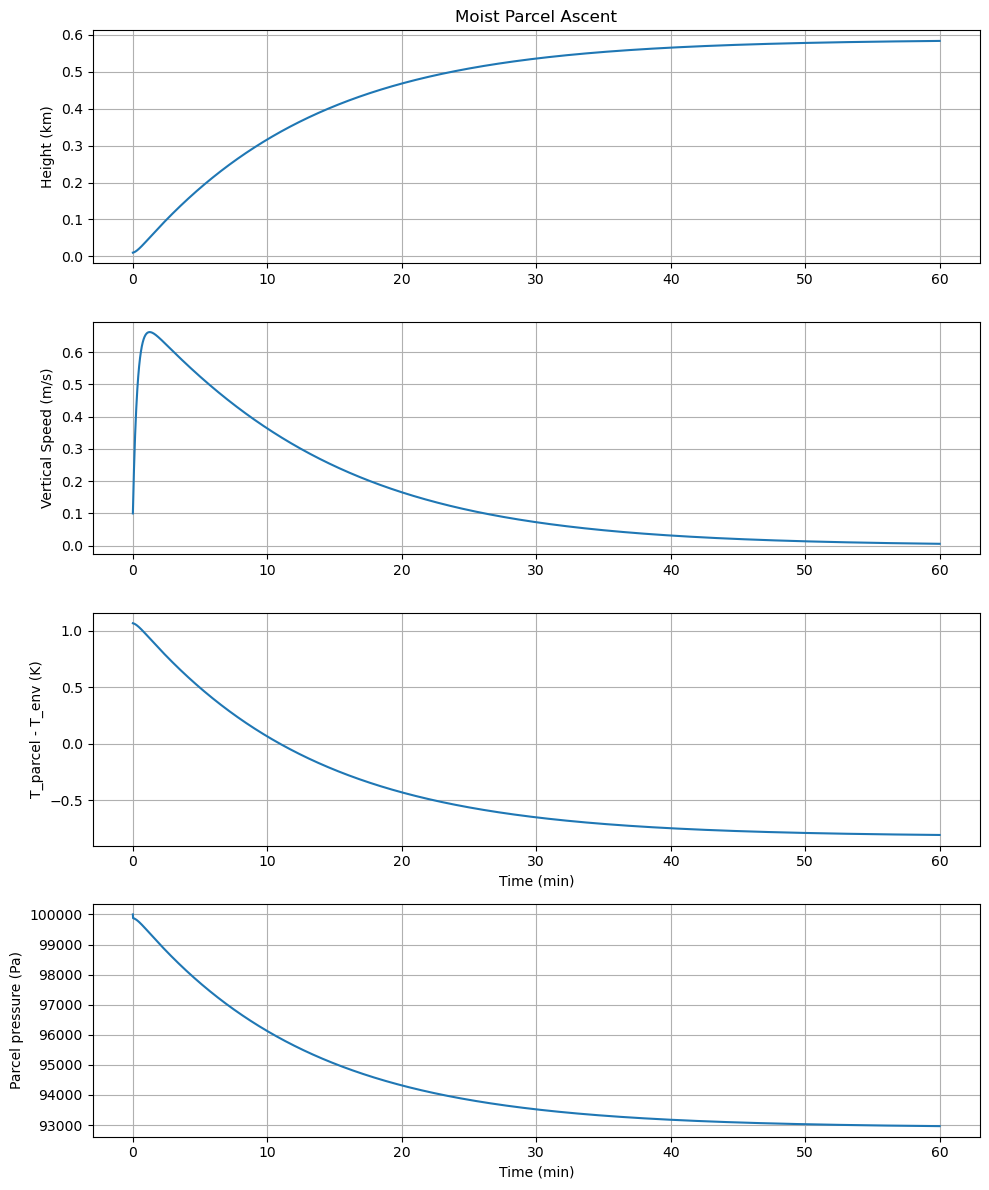

Max height: 0.6 km
Max speed: 0.7 m/s
Final T perturbation: -0.81 K
Final Pressure: 92964.41 Pa


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81  # m/s^2
cp = 1005  # J/kg/K
Rd = 287  # J/kg/K
Rv = 461  # J/kg/K
L = 2.5e6  # J/kg/K
eps = 0.622  # Rd/Rv
T0 = 273.15  # K
p0 = 1e5  # Pa
R = Rd  # J/kg/K
epsilon_drag = 0.05  # 1/s, linear drag
mu_entrain = 1e-4  # 1/m, entrainment rate

def sat_mix_ratio(T, p):
    """Saturation mixing ratio q_s(T,p)"""
    es = 1710 * np.exp((T - 288) / 16.5)  # Pa, Clausius-Clapeyron
    e = es * p / (p + 0.378 * es)  # Partial pressure
    return eps * e / (p - e)

def moist_lapse_rate(T, p):
    """Moist adiabatic lapse rate (K/m)"""
    q_s = sat_mix_ratio(T, p)
    Gamma_d = g / cp * 1e3  # K/km dry
    Lv = L / cp * 1e3  # K
    r = 1 + L * q_s / (Rd * T)
    denom = 1 + (L**2 * q_s * eps) / (cp * Rv * T**2)
    return Gamma_d * r / denom / 1e3  # K/m

# Environment profile (exponential + tropopause)
def env_T(z):
    """Vectorized environment temperature profile for array or scalar z (m)."""
    z = np.asarray(z)
    T = np.empty_like(z, dtype=float)
    mask = z < 15000.0
    T[mask] = 301.0 - 6.5e-3 * z[mask]    # troposphere
    T[~mask] = 216.65                     # tropopause
    return T


def env_q(z):
    return 0.018 * np.exp(-z / 2000)  # kg/kg, decreasing with height

# Time stepping
dt = 1.0  # s
t_max = 3600  # 1 hour
N = int(t_max / dt)
t = np.linspace(0, t_max, N)

# Initial conditions (surface, near saturation)
z = np.zeros(N)
w = np.zeros(N)
T_p = np.full(N, 302.0)  # K, warm SST
q_p = np.full(N, 0.018)  # kg/kg near saturation
p_p = np.full(N, p0)

z[0] = 10.0  # m initial height
w[0] = 0.1   # m/s gentle start

# Integration loop
for i in range(1, N):
    # Current state
    p_env = p0 * np.exp(-z[i-1] / 8000)  # Hydrostatic
    p_p[i] = p_env  # Parcel pressure ≈ environment
    
    T_e = env_T(z[i-1])
    q_e = env_q(z[i-1])
    q_s = sat_mix_ratio(T_p[i-1], p_p[i-1])
    
    # Virtual temperature perturbations
    Tv_p = T_p[i-1] * (1 + 0.608 * q_p[i-1])
    Tv_e = T_e * (1 + 0.608 * q_e)
    
    # Buoyancy acceleration
    B = g * (Tv_p - Tv_e) / Tv_e
    
    # Vertical momentum w/ drag
    dwdt = B - epsilon_drag * w[i-1]
    w[i] = w[i-1] + dwdt * dt
    if w[i] < 0: w[i] = 0  # No descent
    
    # Position update
    z[i] = z[i-1] + w[i] * dt
    
    # Thermodynamics: moist ascent when saturated
    if q_p[i-1] >= q_s * 0.99:  # Saturated
        Gamma_m = moist_lapse_rate(T_p[i-1], p_p[i-1])
        dTdt = -Gamma_m * w[i]
        # Condensation
        dqdt_cond = - (L / cp) * (q_p[i-1] - q_s) * w[i] / 8000  # Simple
    else:  # Unsaturated (dry adiabatic)
        dTdt = - (g / cp) * w[i]
        dqdt_cond = 0
    
    # Entrainment
    dqdt_entr = mu_entrain * (q_e - q_p[i-1]) * np.abs(w[i]) / max(z[i], 100)
    
    # Updates
    T_p[i] = T_p[i-1] + dTdt * dt
    q_p[i] = q_p[i-1] + (dqdt_cond + dqdt_entr) * dt

# Plot results
fig, (ax1, ax2, ax3,ax4) = plt.subplots(4, 1, figsize=(10, 12))

ax1.plot(t/60, z/1000)
ax1.set_ylabel('Height (km)')
ax1.set_title('Moist Parcel Ascent')
ax1.grid(True)

ax2.plot(t/60, w)
ax2.set_ylabel('Vertical Speed (m/s)')
ax2.grid(True)

ax3.plot(t/60, T_p - env_T(z))
ax3.set_ylabel('T_parcel - T_env (K)')
ax3.set_xlabel('Time (min)')
ax3.grid(True)

ax4.plot(t/60, p_p)
ax4.set_ylabel('Parcel pressure (Pa)')
ax4.set_xlabel('Time (min)')
ax4.grid(True)

plt.tight_layout()
plt.show()

print(f"Max height: {np.max(z)/1000:.1f} km")
print(f"Max speed: {np.max(w):.1f} m/s")
print(f"Final T perturbation: {T_p[-1] - env_T(z[-1]):.2f} K")
print(f"Final Pressure: {(p_p[-1]):.2f} Pa")


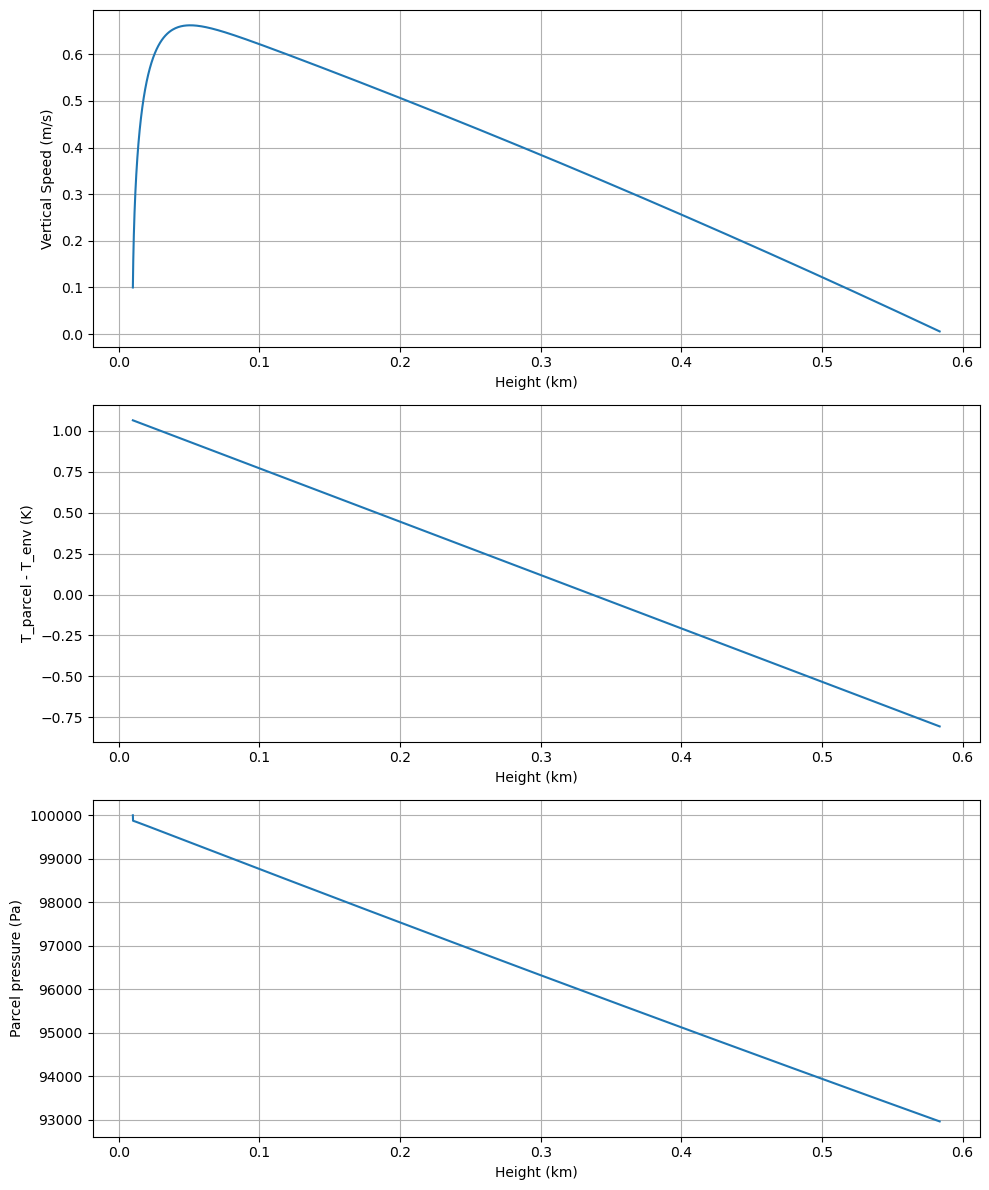

In [2]:
# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
ax1.plot(z/1000, w)
ax1.set_ylabel('Vertical Speed (m/s)')
ax1.set_xlabel('Height (km)')
ax1.grid(True)

ax2.plot(z/1000, T_p - env_T(z))
ax2.set_ylabel('T_parcel - T_env (K)')
ax2.set_xlabel('Height (km)')
ax2.grid(True)

ax3.plot(z/1000, p_p)
ax3.set_ylabel('Parcel pressure (Pa)')
ax3.set_xlabel('Height (km)')
ax3.grid(True)

plt.tight_layout()
plt.show()

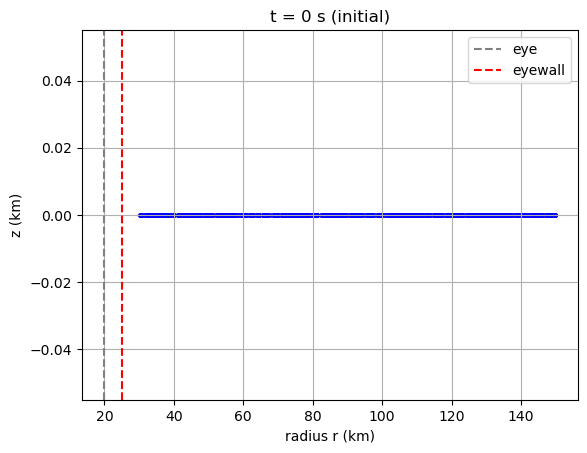

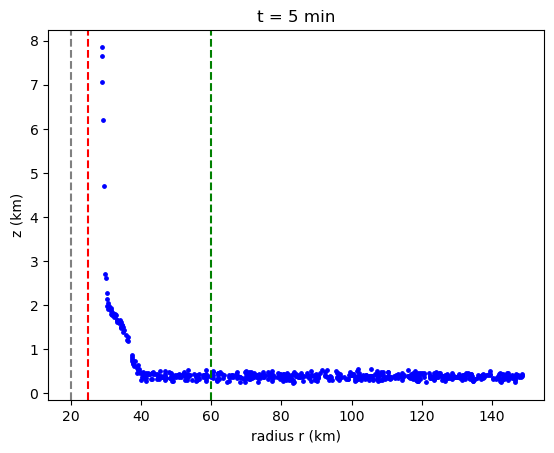

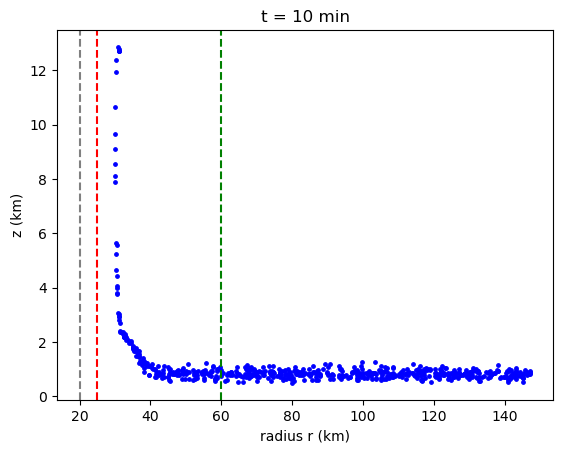

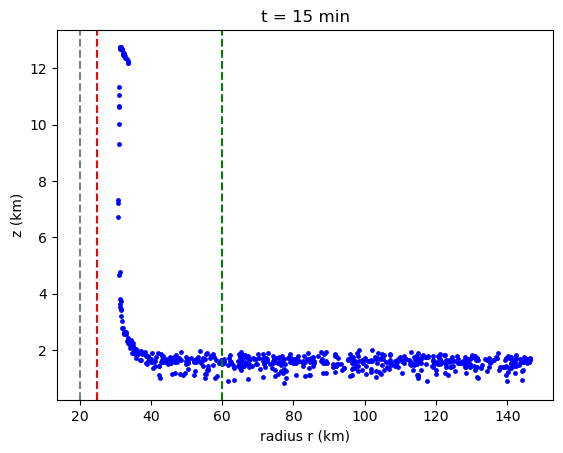

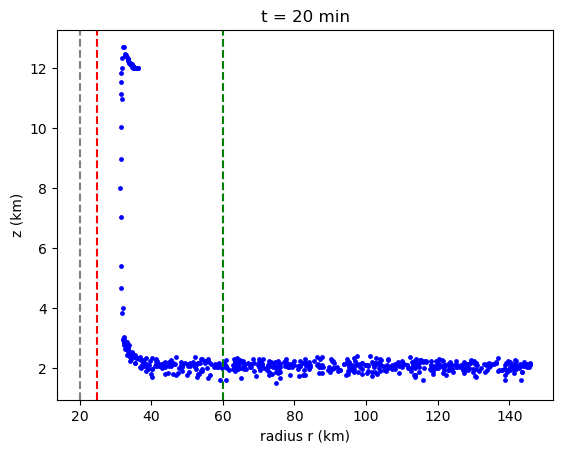

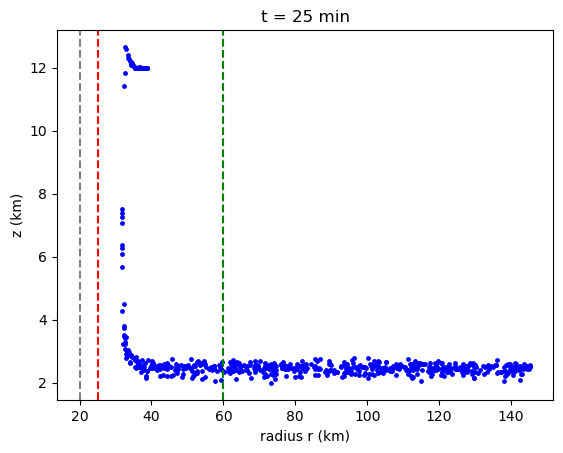

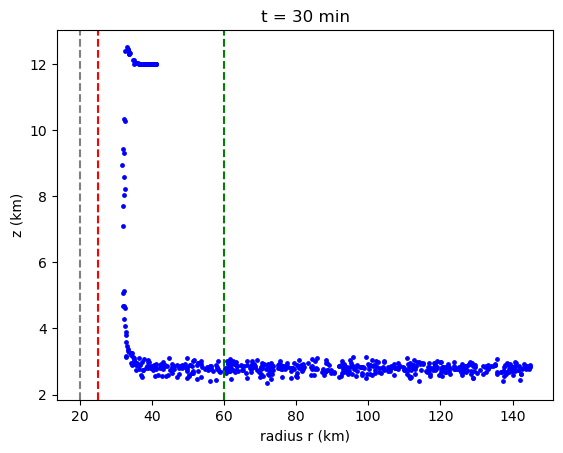

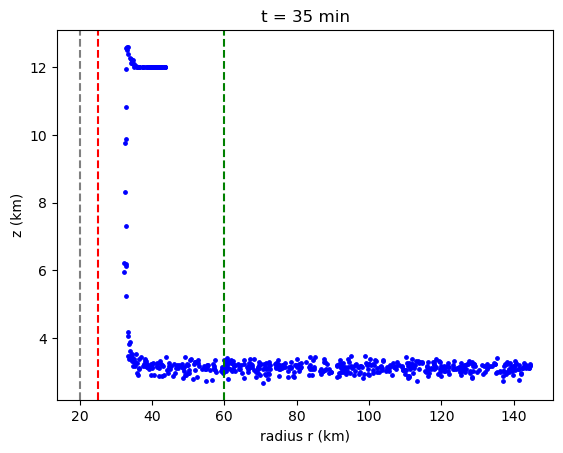

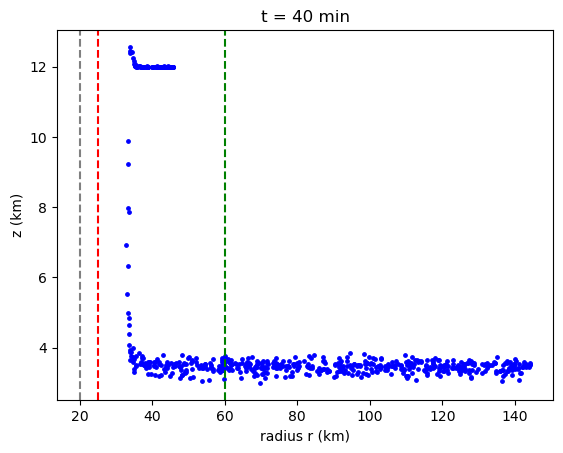

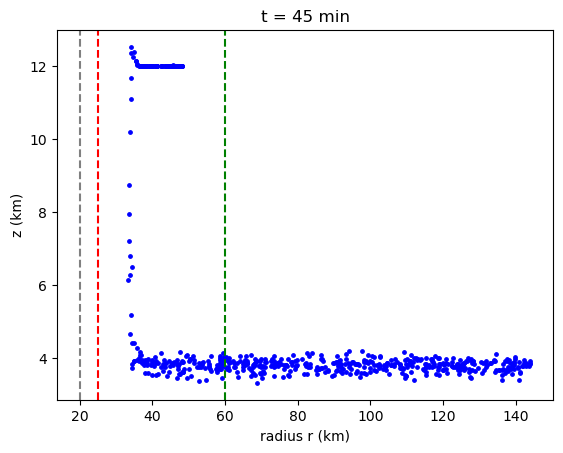

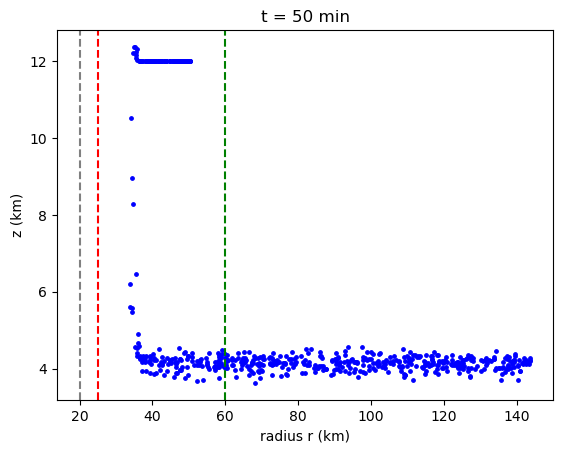

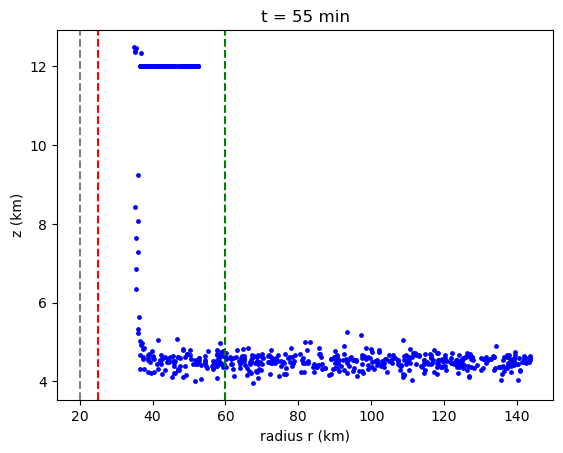

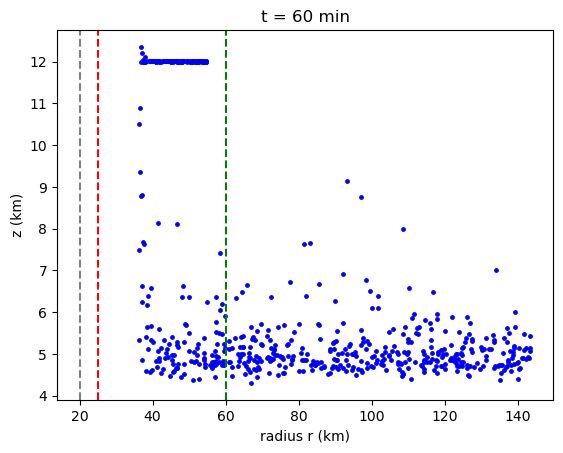

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------- CONSTANTS -----------------
g = 9.81
cp = 1005.0
Rd = 287.0
Rv = 461.0
L = 2.5e6
eps = 0.622
T0 = 273.15
p0 = 1e5
epsilon_drag = 0.05
mu_entrain = 1e-4

# ----------------- HURRICANE RADII (m) -----------------
r_eye = 20e3      # eye radius
r_ew  = 25e3      # eyewall radius
r_rb  = 60e3      # first rainband
r_max = 150e3     # outer domain

# ----------------- THERMODYNAMICS -----------------

def sat_mix_ratio(T, p):
    es = 1710 * np.exp((T - 288) / 16.5)  # Pa, Clausius-Clapeyron
    e = es * p / (p + 0.378 * es)
    return eps * e / (p - e)

def moist_lapse_rate(T, p):
    q_s = sat_mix_ratio(T, p)
    Gamma_d = g / cp
    num = 1.0 + L * q_s / (Rd * T)
    den = 1.0 + (L**2 * q_s * eps) / (cp * Rv * T**2)
    return Gamma_d * num / den   # K/m

def env_T(z):
    z = np.asarray(z)
    T = np.empty_like(z, dtype=float)
    mask = z < 12000.0
    T[mask] = 300.0 - g/cp* z[mask]
    T[~mask] = 216.65
    return T

def env_q(z):
    return 0.018 * np.exp(-z / 8480.0)

# ----------------- SECONDARY CIRCULATION -----------------

def inflow_radial_velocity(r, z, Vmax_in=15.0):
    """Boundary-layer inflow toward center outside eye."""
    fr = np.exp(-((r - 2.0*r_eye)/(0.7*r_max))**2)
    fr *= (r > r_eye)
    fz = np.exp(-z / 2000.0)      # mostly below 2 km
    return -Vmax_in * fr * fz     # negative = inward

def outflow_radial_velocity(r, z, Vmax_out=10.0):
    """Upper-level outflow above ~10 km."""
    fz = np.exp(-((z - 12000.0)/3000.0)**2)
    fr = np.exp(-(r/(0.6*r_max))**2)
    return Vmax_out * fr * fz     # positive = outward

def eyewall_updraft_forcing(r, z, W0=4.0, sigma_r=5e3):
    fr = np.exp(-0.5*((r - r_ew)/sigma_r)**2)
    fz = np.exp(-z/8000.0)
    return W0 * fr * fz

'''def rainband_updraft_forcing(r, z, W0=2.0, sigma_r=10e3):
    fr = np.exp(-0.5*((r - r_rb)/sigma_r)**2)
    fz = np.exp(-z/8000.0)
    return W0 * fr * fz'''

def eye_subsidence_forcing(r, z, W0=1.0):
    fr = np.exp(-0.5*(r/(0.6*r_eye))**2)
    fz = np.exp(-((z - 6000.0)/4000.0)**2)
    return -W0 * fr * fz



def simulate_hurricane_parcels(
        Npar=600,
        t_max=3600.0,
        dt=1.0
    ):
    """
    Simple axisymmetric hurricane cross-section in (r,z) using Lagrangian parcels.
    r = radius from center, z = height.
    Eyewall at r_ew, rainband at r_rb, weak eye subsidence at r<r_eye.
    """

    N = int(t_max / dt) + 1

    # --- initial parcels: low-level ring outside eyewall ---
    r = np.random.uniform(r_ew + 5e3, r_max, size=Npar)
    z = np.full(Npar, 0.0)  
    w = np.full(Npar, 0.1)
    T_p = np.full(Npar, 302.0) + np.random.normal(0, 0.3, size=Npar)
    q_p = np.full(Npar, 0.018)
    condensate = np.zeros(Npar)

    # plot initial state
    plt.figure()
    plt.scatter(r/1000.0, z/1000.0, c='blue', s=6)
    plt.axvline(r_eye/1000.0, color='gray', ls='--', label='eye')
    plt.axvline(r_ew/1000.0,  color='r',   ls='--', label='eyewall')
    #plt.axvline(r_rb/1000.0,  color='g',   ls='--', label='rainband')
    plt.xlabel('radius r (km)')
    plt.ylabel('z (km)')
    plt.title('t = 0 s (initial)')
    plt.legend()
    plt.grid(True)
    plt.show()

    for n in range(1, N):
        t = n * dt

        # environment
        p_env = p0 * np.exp(-z / 8000.0)
        p_p = p_env.copy()
        T_e = env_T(z)
        q_e = env_q(z)
        q_s = sat_mix_ratio(T_p, p_p)

        # buoyancy
        Tv_p = T_p * (1.0 + 0.608 * q_p)
        Tv_e = T_e * (1.0 + 0.608 * q_e)
        B = g * (Tv_p - Tv_e) / Tv_e

        # secondary circulation forcings
        w_forcing = (eyewall_updraft_forcing(r, z) +
                     #rainband_updraft_forcing(r, z) +
                     eye_subsidence_forcing(r, z))
        u_r = inflow_radial_velocity(r, z) + outflow_radial_velocity(r, z)

        # thermodynamics & condensation
        saturated = q_p >= 0.99 * q_s
        dTdt = np.zeros_like(T_p)
        dqdt_cond = np.zeros_like(q_p)

        if np.any(saturated):
            Gamma_m = moist_lapse_rate(T_p[saturated], p_p[saturated])
            dTdt[saturated] = -Gamma_m * w[saturated]
            dq_excess = np.maximum(q_p[saturated] - q_s[saturated], 0.0)
            dqdt_cond[saturated] = -dq_excess * np.maximum(w[saturated], 0.0) / 8000.0
            condensate[saturated] += -dqdt_cond[saturated] * dt

        dry = ~saturated
        dTdt[dry] = - (g / cp) * w[dry]

        cond_rate = -dqdt_cond

        # simple rain‑induced downdrafts (below 7 km where heavy condensation)
        thresh = 1e-6
        heavy = cond_rate > thresh
        Wd = 3.0
        downdraft = np.zeros_like(w)
        mask_dd = (z < 7000.0) & heavy
        downdraft[mask_dd] = -Wd * np.exp(-z[mask_dd] / 3000.0)

        # vertical momentum
        dwdt = B - epsilon_drag * w + w_forcing + downdraft
        w = np.clip(w + dwdt * dt, -15.0, 50.0)

        # radial and vertical position
        r = np.clip(r + u_r * dt, 0.0, r_max)
        z = np.maximum(z + w * dt, 0.0)

        # entrainment
        dqdt_entr = mu_entrain * (q_e - q_p) * np.abs(w) / np.maximum(z, 100.0)

        # update T and q
        T_p = T_p + dTdt * dt
        q_p = q_p + (dqdt_cond + dqdt_entr) * dt

        # plot every 300 s (5 min) for evolution
        if n % 300 == 0 or n == N-1:
            plt.figure()
            plt.scatter(r/1000.0, z/1000.0, c='blue', s=6)
            plt.axvline(r_eye/1000.0, color='gray', ls='--', label='eye')
            plt.axvline(r_ew/1000.0,  color='r',   ls='--', label='eyewall')
            plt.axvline(r_rb/1000.0,  color='g',   ls='--', label='rainband')
            plt.xlabel('radius r (km)')
            plt.ylabel('z (km)')
            plt.title(f't = {t/60:.0f} min')


simulate_hurricane_parcels()